In [9]:
import torch
import torch.nn as nn
import torchvision
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
import torchvision.transforms as transforms

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.version.cuda)  # Should show the CUDA version PyTorch was compiled with
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of your GPU (if available)


True
12.1
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [11]:
# ----------------------
# Step 2: Random GAN Model
# ----------------------
class RandomGAN(nn.Module):
    def __init__(self):
        super(RandomGAN, self).__init__()

    def forward(self, x):
        return torch.randn((128, 3, 32, 32)).clip(0, 1)

GAN = RandomGAN()

# Function to generate images from RandomGAN
def generate_imgs():
    x = torch.randn((128, 100))
    return GAN(x).cuda()



# ----------------------
# Step 3: Copycat Model
# ----------------------
class CopycatModel:
    """A model that outputs training samples as its generated samples."""
    def __init__(self, train_dataset):
        self.transform = transforms.Compose([transforms.ToTensor()])  # Ensure all images are converted to tensors
        self.train_images = torch.stack([self.transform(train_dataset[i][0]) for i in range(len(train_dataset))])
        self.index = 0

    def generate_samples(self, batch_size=128):
        """Return a batch of training images, simulating overfitting."""
        batch = self.train_images[self.index : self.index + batch_size]
        self.index = (self.index + batch_size) % len(self.train_images)
        return batch

In [5]:
# ----------------------
# Step 4: Load Datasets
# ----------------------
train_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=False, download=True)
test_dataset.name = "CIFAR10_test"

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# ----------------------
# Step 5: Feature Extraction
# ----------------------
feature_extractor = InceptionFeatureExtractor()

# Compute features for train and test datasets
print("Extracting features for datasets...")
train_feat = feature_extractor.get_dataset_features(train_dataset)
test_feat = feature_extractor.get_dataset_features(test_dataset)


Extracting features for datasets...


In [8]:
# ----------------------
# Step 6: Random GAN Features
# ----------------------
print("Extracting features for RandomGAN...")
random_gan_feat = feature_extractor.get_model_features(generate_imgs, num_samples=10_000)

Extracting features for RandomGAN...


100%|██████████| 79/79 [05:43<00:00,  4.35s/it]


In [12]:
# ----------------------
# Step 7: Copycat Model Features
# ----------------------
print("Extracting features for Copycat model...")
copycat_model = CopycatModel(train_dataset)

def copycat_generate():
    return copycat_model.generate_samples(batch_size=128)

copycat_feat = feature_extractor.get_model_features(copycat_generate, num_samples=10_000)

Extracting features for Copycat model...


100%|██████████| 79/79 [05:33<00:00,  4.22s/it]


In [ ]:

# ----------------------
# Step 8: Compute Metrics
# ----------------------
fld = FLD()
fid = FID()

train_feat_cpu = train_feat.cpu()
test_feat_cpu = test_feat.cpu()
random_gan_feat_cpu = random_gan_feat.cpu()
copycat_feat_cpu = copycat_feat.cpu()

# Compute FLD & FID with CPU features
random_gan_fld = fld.compute_metric(train_feat_cpu, test_feat_cpu, random_gan_feat_cpu)


random_gan_fid_train = fid.compute_metric(train_feat_cpu, None, random_gan_feat_cpu)
random_gan_fid_test = fid.compute_metric(test_feat_cpu, None, random_gan_feat_cpu)
random_gan_gen_gap = FLD("gap").compute_metric(train_feat_cpu, test_feat_cpu, random_gan_feat_cpu)


copycat_fld = fld.compute_metric(train_feat_cpu, test_feat_cpu, copycat_feat_cpu)
copycat_fid_train = fid.compute_metric(train_feat_cpu, None, copycat_feat_cpu)
copycat_fid_test = fid.compute_metric(test_feat_cpu, None, copycat_feat_cpu)
copycat_gen_gap = FLD("gap").compute_metric(train_feat_cpu, test_feat_cpu, copycat_feat_cpu)


# ----------------------
# Step 9: Display Results
# ----------------------
print("\n--- Evaluation Results ---")
print("RandomGAN Metrics:")
print(f"  FLD: {random_gan_fld:.2f}")
print(f"  FID (Train): {random_gan_fid_train:.2f}")
print(f"  FID (Test): {random_gan_fid_test:.2f}")
print(f"  Generalization Gap: {random_gan_gen_gap:.2f}")

print("\nCopycat Metrics:")
print(f"  FLD: {copycat_fld:.2f}")
print(f"  FID (Train): {copycat_fid_train:.2f}")
print(f"  FID (Test): {copycat_fid_test:.2f}")
print(f"  Generalization Gap: {copycat_gen_gap:.2f}")

c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:78: UserWarning: Very high FLD value, your generated data is likely completely memorized.
  warnings.warn(



--- Evaluation Results ---
RandomGAN Metrics:
  FLD: 55.97
  FID (Train): 440.21
  FID (Test): 440.48
  Generalization Gap: 0.06

Copycat Metrics:
  FLD: 814240.33
  FID (Train): 2.12
  FID (Test): 5.20
  Generalization Gap: -163051.56


c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(


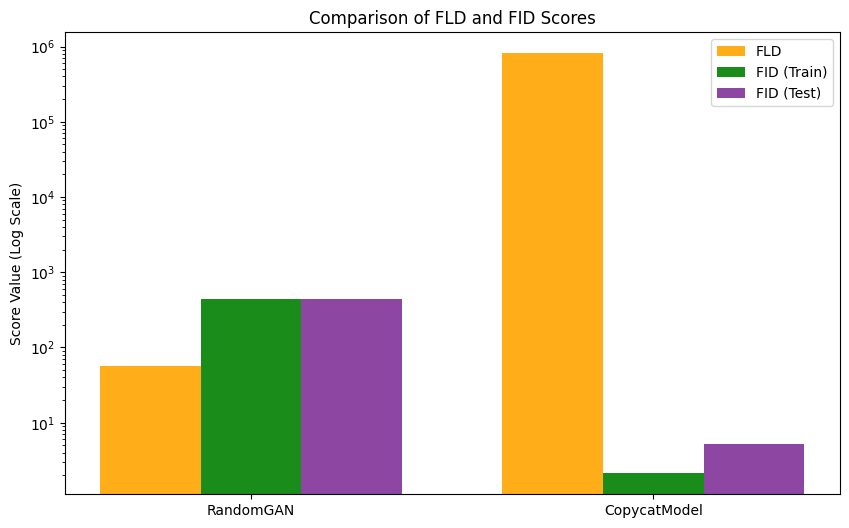

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ["RandomGAN", "CopycatModel"]

fld_scores = [random_gan_fld, copycat_fld]
fid_train_scores = [random_gan_fid_train, copycat_fid_train]
fid_test_scores = [random_gan_fid_test, copycat_fid_test]

# ----------------------
# Plot Comparison of FLD and FID Scores
# ----------------------
x = np.arange(len(models))  # Label positions
width = 0.25  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, fld_scores, width, label="FLD", alpha = 0.9, color='orange')
rects2 = ax.bar(x, fid_train_scores, width, label="FID (Train)",alpha = 0.9, color='green')
rects3 = ax.bar(x + width, fid_test_scores, width, label="FID (Test)", alpha = 0.9, color='#823299')

ax.set_ylabel("Score Value (Log Scale)")
ax.set_title("Comparison of FLD and FID Scores")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_yscale("log")  # Use log scale due to large differences in FLD

plt.show()
